In [72]:
# --------------------------
import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ STEP 1: Libraries imported successfully")

✅ STEP 1: Libraries imported successfully


In [73]:
try:
    BASE_PATH = r"C:\Users\saich\charan\kidney\data"
    CKD_PATH = os.path.join(BASE_PATH, "CKD")
    HEALTHY_PATH = os.path.join(BASE_PATH, "Healthy_Control")
    CSV_PATH = os.path.join(BASE_PATH, "subject_information.csv")
    
    # Verify paths exist
    assert os.path.exists(CKD_PATH), f"CKD path not found: {CKD_PATH}"
    assert os.path.exists(HEALTHY_PATH), f"Healthy path not found: {HEALTHY_PATH}"
    assert os.path.exists(CSV_PATH), f"CSV file not found: {CSV_PATH}"
    
    print("✅ STEP 2: Paths configured correctly")
    print(f"Found {len(os.listdir(CKD_PATH))} CKD files")
    print(f"Found {len(os.listdir(HEALTHY_PATH))} Healthy files")
except Exception as e:
    print(f"❌ Error in STEP 2: {str(e)}")
    raise

✅ STEP 2: Paths configured correctly
Found 100 CKD files
Found 100 Healthy files


In [74]:
def load_nifti_data():
    try:
        print("\nLoading subject information...")
        subject_info = pd.read_csv(CSV_PATH)
        print(f"Loaded info for {len(subject_info)} subjects")
        
        def process_folder(folder_path, is_ckd):
            images, labels, stages = [], [], []
            prefix = "CKD_" if is_ckd else "HC_"
            
            for file in os.listdir(folder_path):
                if file.endswith('.nii') and not file.endswith('_mask.nii'):
                    try:
                        # Extract subject ID - MODIFIED THIS PART
                        subject_id = file.split('_T2W')[0]  # This will get "CKD_01" from "CKD_01_T2W.nii"
                        
                        # Load image
                        img_path = os.path.join(folder_path, file)
                        img = nib.load(img_path).get_fdata()
                        
                        # Get metadata
                        info_row = subject_info[subject_info['Label'] == subject_id]
                        if info_row.empty:
                            print(f"⚠️ No metadata for {file} (looked for {subject_id})")
                            continue
                            
                        # Process image (3D -> 2D if needed)
                        if len(img.shape) == 3:
                            img = img[:, :, img.shape[2]//2]  # Middle slice
                            
                        # Normalize and resize
                        img = (img - np.min(img)) / (np.max(img) - np.min(img))
                        img = tf.image.resize(img[..., np.newaxis], (256, 256)).numpy()[..., 0]
                        
                        images.append(img)
                        labels.append(info_row['CKD'].values[0])
                        stages.append(info_row['CKD_Stage'].values[0])
                        print(f"✓ Successfully processed {file} as {subject_id}")
                        
                    except Exception as e:
                        print(f"⚠️ Error processing {file}: {str(e)}")
                        continue
            
            return np.array(images), np.array(labels), np.array(stages)
        
        print("\nProcessing CKD images...")
        ckd_images, ckd_labels, ckd_stages = process_folder(CKD_PATH, True)
        print(f"Loaded {len(ckd_images)} CKD samples")
        
        print("Processing Healthy images...")
        healthy_images, healthy_labels, healthy_stages = process_folder(HEALTHY_PATH, False)
        print(f"Loaded {len(healthy_images)} Healthy samples")
        
        # Combine datasets
        all_images = np.concatenate([ckd_images, healthy_images])
        all_labels = np.concatenate([ckd_labels, healthy_labels])
        all_stages = np.concatenate([ckd_stages, healthy_stages])
        
        print("\n✅ STEP 3: Data loading complete")
        print(f"Total images: {len(all_images)}")
        print(f"Class balance: {np.sum(all_labels)} CKD vs {len(all_labels)-np.sum(all_labels)} Healthy")
        
        return all_images, all_labels, all_stages
    
    except Exception as e:
        print(f"❌ Error in STEP 3: {str(e)}")
        raise

# Test the function
print("\n=== Testing Data Loading ===")
images, labels, stages = load_nifti_data()
print("\nTest completed successfully!")


=== Testing Data Loading ===

Loading subject information...
Loaded info for 60 subjects

Processing CKD images...
✓ Successfully processed CKD_01_T2W.nii as CKD_01
✓ Successfully processed CKD_02_T2W.nii as CKD_02
✓ Successfully processed CKD_03_T2W.nii as CKD_03
✓ Successfully processed CKD_04_T2W.nii as CKD_04
✓ Successfully processed CKD_05_T2W.nii as CKD_05
✓ Successfully processed CKD_06_T2W.nii as CKD_06
✓ Successfully processed CKD_07_T2W.nii as CKD_07
✓ Successfully processed CKD_08_T2W.nii as CKD_08
✓ Successfully processed CKD_09_T2W.nii as CKD_09
✓ Successfully processed CKD_10_T2W.nii as CKD_10
✓ Successfully processed CKD_11_T2W.nii as CKD_11
✓ Successfully processed CKD_12_T2W.nii as CKD_12
✓ Successfully processed CKD_13_T2W.nii as CKD_13
✓ Successfully processed CKD_14_T2W.nii as CKD_14
✓ Successfully processed CKD_15_T2W.nii as CKD_15
✓ Successfully processed CKD_16_T2W.nii as CKD_16
✓ Successfully processed CKD_17_T2W.nii as CKD_17
✓ Successfully processed CKD_18_T2

In [75]:
try:
    images, labels, stages = load_nifti_data()
    
    # Add channel dimension
    images = np.expand_dims(images, axis=-1)
    
    # Split data
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        images, labels, stages, test_size=0.2, random_state=42)
    
    # Prepare stage labels
    stage_encoder = LabelEncoder()
    s_train_encoded = stage_encoder.fit_transform(s_train[y_train])
    s_test_encoded = stage_encoder.transform(s_test[y_test])
    
    s_train_onehot = to_categorical(s_train_encoded)
    s_test_onehot = to_categorical(s_test_encoded)
    
    # Create full stage arrays
    full_s_train = np.zeros((len(y_train), 5))
    full_s_train[y_train] = s_train_onehot
    
    full_s_test = np.zeros((len(y_test), 5))
    full_s_test[y_test] = s_test_onehot
    
    print("\n✅ STEP 4: Data preparation complete")
    print(f"Train shapes: X={X_train.shape}, y={y_train.shape}, s={full_s_train.shape}")
    print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, s={full_s_test.shape}")
    
except Exception as e:
    print(f"❌ Error in STEP 4: {str(e)}")
    raise


Loading subject information...
Loaded info for 60 subjects

Processing CKD images...
✓ Successfully processed CKD_01_T2W.nii as CKD_01
✓ Successfully processed CKD_02_T2W.nii as CKD_02
✓ Successfully processed CKD_03_T2W.nii as CKD_03
✓ Successfully processed CKD_04_T2W.nii as CKD_04
✓ Successfully processed CKD_05_T2W.nii as CKD_05
✓ Successfully processed CKD_06_T2W.nii as CKD_06
✓ Successfully processed CKD_07_T2W.nii as CKD_07
✓ Successfully processed CKD_08_T2W.nii as CKD_08
✓ Successfully processed CKD_09_T2W.nii as CKD_09
✓ Successfully processed CKD_10_T2W.nii as CKD_10
✓ Successfully processed CKD_11_T2W.nii as CKD_11
✓ Successfully processed CKD_12_T2W.nii as CKD_12
✓ Successfully processed CKD_13_T2W.nii as CKD_13
✓ Successfully processed CKD_14_T2W.nii as CKD_14
✓ Successfully processed CKD_15_T2W.nii as CKD_15
✓ Successfully processed CKD_16_T2W.nii as CKD_16
✓ Successfully processed CKD_17_T2W.nii as CKD_17
✓ Successfully processed CKD_18_T2W.nii as CKD_18
✓ Successfully

In [76]:
#step-5

try:
    def create_model(input_shape):
        inputs = Input(shape=input_shape)
        
        # Feature extraction
        x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2,2))(x)
        x = Flatten()(x)
        
        # Output 1: CKD classification
        binary_out = Dense(1, activation='sigmoid', name='ckd_status')(x)
        
        # Output 2: Stage prediction
        stage_branch = Dense(128, activation='relu')(x)
        stage_branch = Dropout(0.5)(stage_branch)
        stage_out = Dense(5, activation='softmax', name='ckd_stage')(stage_branch)
        
        return Model(inputs=inputs, outputs=[binary_out, stage_out])
    
    model = create_model(X_train.shape[1:])
    model.summary()
    
    print("\n✅ STEP 5: Model created successfully")
    
except Exception as e:
    print(f"❌ Error in STEP 5: {str(e)}")
    raise

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 256, 256, 32)      │             320 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 128, 128, 32)      │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 64, 64, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 32, 32, 128)       │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 131072)            │               0 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │      16,777,344 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ckd_status (Dense)            │ (None, 1)                 │         131,073 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ckd_stage (Dense)             │ (None, 5)                 │             645 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 17,001,734 (64.86 MB)

 Trainable params: 17,001,734 (64.86 MB)

 Non-trainable params: 0 (0.00 B)


✅ STEP 5: Model created successfully


In [77]:
#step-6

try:
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss={
            'ckd_status': 'binary_crossentropy',
            'ckd_stage': 'categorical_crossentropy'
        },
        loss_weights={
            'ckd_status': 1.0,
            'ckd_stage': 0.7
        },
        metrics={
            'ckd_status': 'accuracy',
            'ckd_stage': 'accuracy'
        }
    )
    
    print("\nStarting training...")
    history = model.fit(
        X_train,
        {
            'ckd_status': y_train,
            'ckd_stage': full_s_train
        },
        validation_data=(
            X_test,
            {
                'ckd_status': y_test,
                'ckd_stage': full_s_test
            }
        ),
        epochs=30,  # Start with fewer epochs for testing
        batch_size=16,
        verbose=1
    )
    
    print("\n✅ STEP 6: Training completed")
    
except Exception as e:
    print(f"❌ Error in STEP 6: {str(e)}")
    raise


Starting training...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - ckd_stage_accuracy: 0.2613 - ckd_stage_loss: 0.8265 - ckd_status_accuracy: 0.5165 - ckd_status_loss: 0.6974 - loss: 1.2760 - val_ckd_stage_accuracy: 0.1500 - val_ckd_stage_loss: 0.9230 - val_ckd_status_accuracy: 0.8000 - val_ckd_status_loss: 0.6822 - val_loss: 1.3572
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - ckd_stage_accuracy: 0.1965 - ckd_stage_loss: 0.7980 - ckd_status_accuracy: 0.7755 - ckd_status_loss: 0.6684 - loss: 1.2270 - val_ckd_stage_accuracy: 0.1500 - val_ckd_stage_loss: 0.9545 - val_ckd_status_accuracy: 0.4000 - val_ckd_status_loss: 0.6724 - val_loss: 1.3580
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - ckd_stage_accuracy: 0.1686 - ckd_stage_loss: 0.8907 - ckd_status_accuracy: 0.5273 - ckd_status_loss: 0.6434 - loss: 1.2669 - val_ckd_stage_accuracy: 0.1000 - val_ckd_stage_loss: 0.9450 - val_ckd_status_accuracy: 0.5000 - val_ckd_status_loss: 0.6490 - val_loss: 1.3278
Epoch 4/30
5/5 ━━━

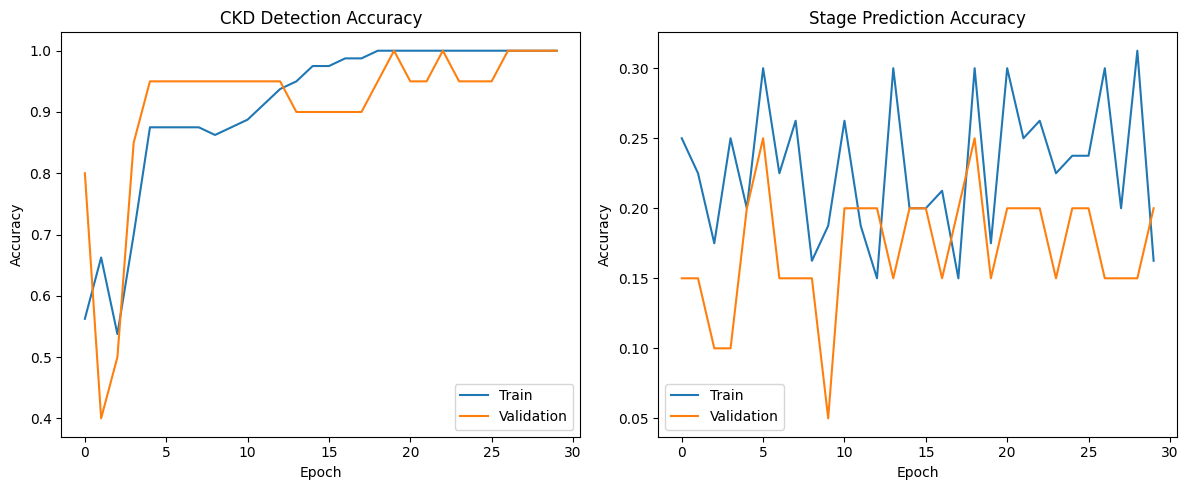


✅ STEP 7: Model saved to C:\Users\saich\charan\kidney\data\kidney_model2.h5

✨ All steps completed successfully! ✨


In [78]:
#step-7

try:
    # Plot training history
    plt.figure(figsize=(12,5))
    
    # Plot binary classification accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['ckd_status_accuracy'], label='Train')
    plt.plot(history.history['val_ckd_status_accuracy'], label='Validation')
    plt.title('CKD Detection Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot stage classification accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['ckd_stage_accuracy'], label='Train')
    plt.plot(history.history['val_ckd_stage_accuracy'], label='Validation')
    plt.title('Stage Prediction Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save model
    model_path = os.path.join(BASE_PATH, "kidney_model2.h5")
    model.save(model_path)
    print(f"\n✅ STEP 7: Model saved to {model_path}")
    
except Exception as e:
    print(f"❌ Error in STEP 7: {str(e)}")
    raise

print("\n✨ All steps completed successfully! ✨")


=== Testing Model Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


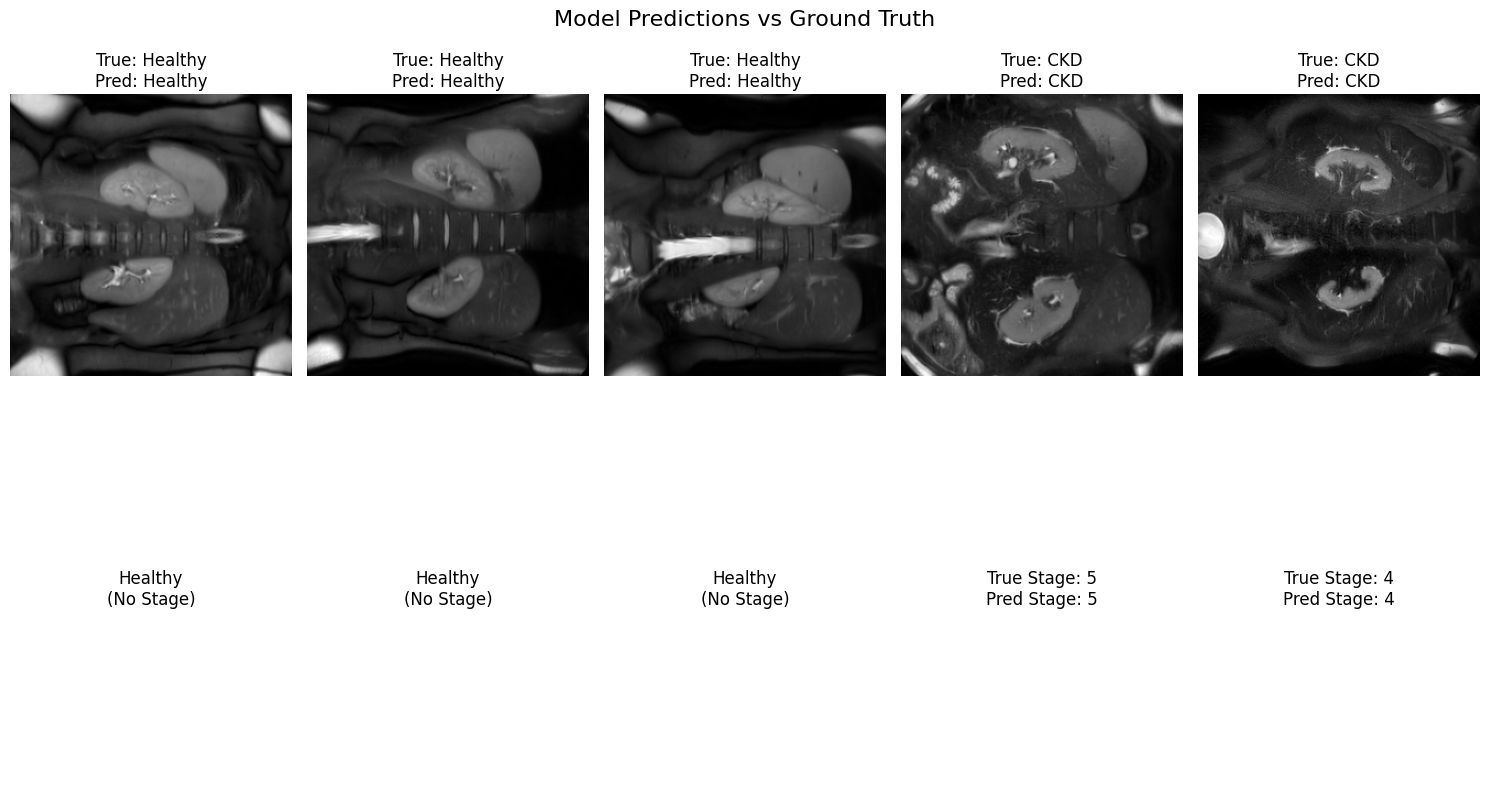


✅ STEP 8: Prediction testing complete


In [79]:
# --------------------------
# STEP 8: Test Predictions
# --------------------------
try:
    print("\n=== Testing Model Predictions ===")
    
    # Load a few samples from test set
    test_samples = 5  # Number of samples to test
    sample_images = X_test[:test_samples]
    true_labels = y_test[:test_samples]
    true_stages = s_test[:test_samples]
    
    # Make predictions
    pred_labels, pred_stages = model.predict(sample_images)
    
    # Convert predictions to readable format
    pred_labels = (pred_labels > 0.5).astype(int)  # Convert probabilities to 0/1
    pred_stages = np.argmax(pred_stages, axis=1) + 1  # Convert to stage numbers (1-5)
    
    # Display results
    plt.figure(figsize=(15, 8))
    for i in range(test_samples):
        plt.subplot(2, test_samples, i+1)
        plt.imshow(sample_images[i,...,0], cmap='gray')
        plt.title(f"True: {'CKD' if true_labels[i] else 'Healthy'}\n"
                 f"Pred: {'CKD' if pred_labels[i] else 'Healthy'}")
        plt.axis('off')
        
        plt.subplot(2, test_samples, i+1+test_samples)
        if true_labels[i]:  # Only show stage if it's CKD
            plt.text(0.5, 0.5, 
                    f"True Stage: {true_stages[i]}\nPred Stage: {pred_stages[i]}",
                    ha='center', va='center', fontsize=12)
        else:
            plt.text(0.5, 0.5, "Healthy\n(No Stage)", 
                    ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    plt.suptitle("Model Predictions vs Ground Truth", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ STEP 8: Prediction testing complete")
    
except Exception as e:
    print(f"❌ Error in STEP 8: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


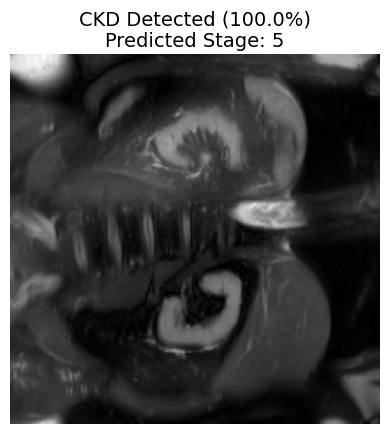

In [107]:
# --------------------------
# STEP 9: Test with External NIfTI File
# --------------------------
def predict_external_nifti(file_path):
    """Predict on a new NIfTI file"""
    try:
        # Load and preprocess the image
        img = nib.load(file_path).get_fdata()
        if len(img.shape) == 3:
            img = img[:, :, img.shape[2]//2]  # Take middle slice
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = tf.image.resize(img[..., np.newaxis], (256, 256)).numpy()[..., 0]
        img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dims
        
        # Predict
        pred_label, pred_stage = model.predict(img)
        ckd_prob = pred_label[0][0]
        stage = np.argmax(pred_stage[0]) + 1
        
        # Display
        plt.imshow(img[0,...,0], cmap='gray')
        if ckd_prob > 0.5:
            plt.title(f"CKD Detected ({ckd_prob*100:.1f}%)\nPredicted Stage: {stage}", fontsize=14)
        else:
            plt.title(f"Healthy Kidney ({100-ckd_prob*100:.1f}% confidence)", fontsize=14)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Example usage:
predict_external_nifti("data/CKD/CKD_20_T2W.nii")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


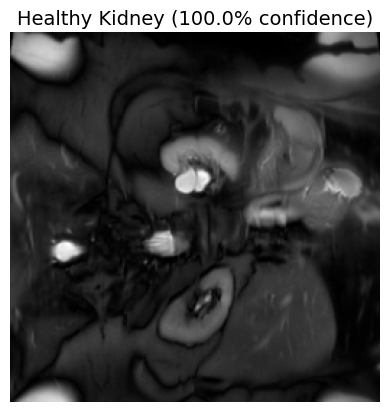

In [108]:
# --------------------------
# STEP 9: Test with External NIfTI File
# --------------------------
def predict_external_nifti(file_path):
    """Predict on a new NIfTI file"""
    try:
        # Load and preprocess the image
        img = nib.load(file_path).get_fdata()
        if len(img.shape) == 3:
            img = img[:, :, img.shape[2]//2]  # Take middle slice
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = tf.image.resize(img[..., np.newaxis], (256, 256)).numpy()[..., 0]
        img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dims
        
        # Predict
        pred_label, pred_stage = model.predict(img)
        ckd_prob = pred_label[0][0]
        stage = np.argmax(pred_stage[0]) + 1
        
        # Display
        plt.imshow(img[0,...,0], cmap='gray')
        if ckd_prob > 0.5:
            plt.title(f"CKD Detected ({ckd_prob*100:.1f}%)\nPredicted Stage: {stage}", fontsize=14)
        else:
            plt.title(f"Healthy Kidney ({100-ckd_prob*100:.1f}% confidence)", fontsize=14)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Example usage:
predict_external_nifti("data/Healthy_Control/HC_03_T2W.nii")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


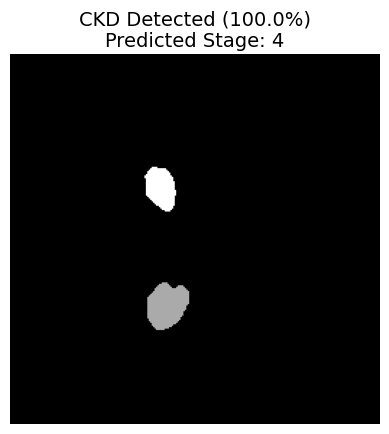

In [109]:
# --------------------------
# STEP 9: Test with External NIfTI File
# --------------------------
def predict_external_nifti(file_path):
    """Predict on a new NIfTI file"""
    try:
        # Load and preprocess the image
        img = nib.load(file_path).get_fdata()
        if len(img.shape) == 3:
            img = img[:, :, img.shape[2]//2]  # Take middle slice
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = tf.image.resize(img[..., np.newaxis], (256, 256)).numpy()[..., 0]
        img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dims
        
        # Predict
        pred_label, pred_stage = model.predict(img)
        ckd_prob = pred_label[0][0]
        stage = np.argmax(pred_stage[0]) + 1
        
        # Display
        plt.imshow(img[0,...,0], cmap='gray')
        if ckd_prob > 0.5:
            plt.title(f"CKD Detected ({ckd_prob*100:.1f}%)\nPredicted Stage: {stage}", fontsize=14)
        else:
            plt.title(f"Healthy Kidney ({100-ckd_prob*100:.1f}% confidence)", fontsize=14)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Example usage:
predict_external_nifti("GT_1.nii")

In [110]:
print("Stage distribution in training:", np.unique(s_train_encoded, return_counts=True))
print("Stage distribution in test:", np.unique(s_test_encoded, return_counts=True))

Stage distribution in training: (array([0, 1, 2, 3, 4], dtype=int64), array([7, 8, 8, 8, 7], dtype=int64))
Stage distribution in test: (array([0, 1, 3, 4], dtype=int64), array([3, 3, 3, 3], dtype=int64))


In [13]:
X = np.array(images)
y_class = np.array(labels)
y_stage = np.array(stages)  # ✅ Now this is defined


CKD Stage Distribution:
Stage 0: 50 samples
Stage 1: 2 samples
Stage 2: 2 samples
Stage 3: 16 samples
Stage 4: 6 samples
Stage 5: 24 samples


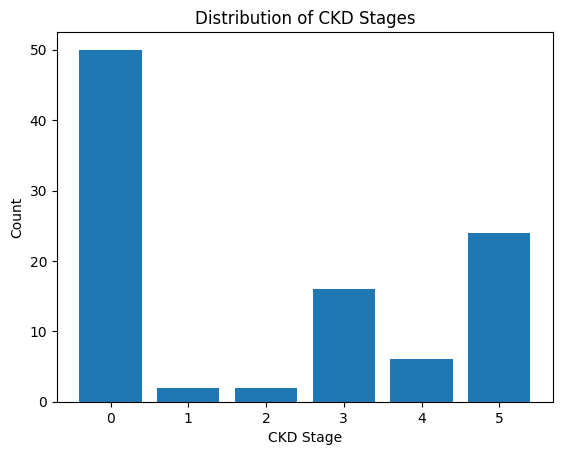

In [14]:
# Analyze CKD Stage Distribution
import matplotlib.pyplot as plt
unique_stages, stage_counts = np.unique(y_stage, return_counts=True)
print("CKD Stage Distribution:")
for s, c in zip(unique_stages, stage_counts):
    print(f"Stage {s}: {c} samples")

plt.bar(unique_stages, stage_counts)
plt.xlabel("CKD Stage")
plt.ylabel("Count")
plt.title("Distribution of CKD Stages")
plt.show()


In [15]:
# Alternative version that handles one-hot encoded stages
from sklearn.utils.class_weight import compute_class_weight

# Get the indices where y_train == 1 (CKD cases)
ckd_indices = np.where(y_train == 1)[0]

# Convert one-hot encoded stages back to class indices for CKD cases
s_train_ckd_classes = np.argmax(full_s_train[ckd_indices], axis=1)

# Calculate class weights
class_weights = compute_class_weight('balanced',
                                   classes=np.arange(5),  # Assuming stages 0-4
                                   y=s_train_ckd_classes)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights for stages:", class_weight_dict)
print("Stage distribution:", np.unique(s_train_ckd_classes, return_counts=True))

Class weights for stages: {0: 3.8, 1: 7.6, 2: 0.5066666666666667, 3: 1.9, 4: 0.475}
Stage distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([ 2,  1, 15,  4, 16], dtype=int64))


In [16]:
# More conservative weights to prevent over-weighting rare stages
adjusted_weights = {
    0: 2.0,  # Stage 1 (originally 3.8)
    1: 3.0,  # Stage 2 (originally 7.6)
    2: 1.0,  # Stage 3 (originally 0.5)
    3: 1.5,  # Stage 4 (originally 1.9)
    4: 0.8   # Stage 5 (originally 0.475)
}

In [17]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
import numpy as np

# First, let's align our datasets properly
print("Original shapes:")
print(f"X_train: {X_train.shape} (images)")
print(f"y_train: {y_train.shape} (labels)")
print(f"full_s_train: {full_s_train.shape} (stage encodings)")

# We need to find which samples have both images and CKD labels
# Get indices where we have both image data and CKD label
valid_indices = np.where(y_train == 1)[0]
valid_indices = valid_indices[valid_indices < len(X_train)]  # Ensure within X_train bounds

print(f"\nNumber of valid CKD cases with images: {len(valid_indices)}")

# Extract only the valid CKD cases that have both image and label data
X_train_ckd = X_train[valid_indices]
s_train_ckd_classes = np.argmax(full_s_train[valid_indices], axis=1)

print("\nValid CKD cases shapes:")
print(f"X_train_ckd: {X_train_ckd.shape}")
print(f"s_train_ckd_classes: {s_train_ckd_classes.shape}")
print("Stage distribution:", np.unique(s_train_ckd_classes, return_counts=True))

# Only proceed if we have valid cases
if len(X_train_ckd) > 0:
    # Resample to balance classes
    ros = RandomOverSampler(random_state=42)
    
    # Flatten images temporarily for resampling
    X_train_flat = X_train_ckd.reshape(len(X_train_ckd), -1)
    
    # Perform oversampling
    X_resampled_flat, s_resampled = ros.fit_resample(X_train_flat, s_train_ckd_classes)
    
    # Reshape back to original image dimensions
    X_resampled = X_resampled_flat.reshape(-1, *X_train.shape[1:])
    
    print("\nAfter resampling:")
    print(f"X_resampled shape: {X_resampled.shape}")
    print(f"s_resampled shape: {s_resampled.shape}")
    print("New stage distribution:", np.unique(s_resampled, return_counts=True))
    
    # Add augmented data to original dataset
    X_train = np.concatenate([X_train, X_resampled])
    y_train = np.concatenate([y_train, np.ones(len(X_resampled))])
    full_s_train = np.concatenate([full_s_train, to_categorical(s_resampled, num_classes=5)])
    
    print("\nFinal augmented dataset shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"full_s_train: {full_s_train.shape}")
else:
    print("Warning: No valid CKD cases with image data found!")

Original shapes:
X_train: (80, 256, 256, 1) (images)
y_train: (80,) (labels)
full_s_train: (80, 5) (stage encodings)

Number of valid CKD cases with images: 38

Valid CKD cases shapes:
X_train_ckd: (38, 256, 256, 1)
s_train_ckd_classes: (38,)
Stage distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([ 2,  1, 15,  4, 16], dtype=int64))

After resampling:
X_resampled shape: (80, 256, 256, 1)
s_resampled shape: (80,)
New stage distribution: (array([0, 1, 2, 3, 4], dtype=int64), array([16, 16, 16, 16, 16], dtype=int64))

Final augmented dataset shapes:
X_train: (160, 256, 256, 1)
y_train: (160,)
full_s_train: (160, 5)


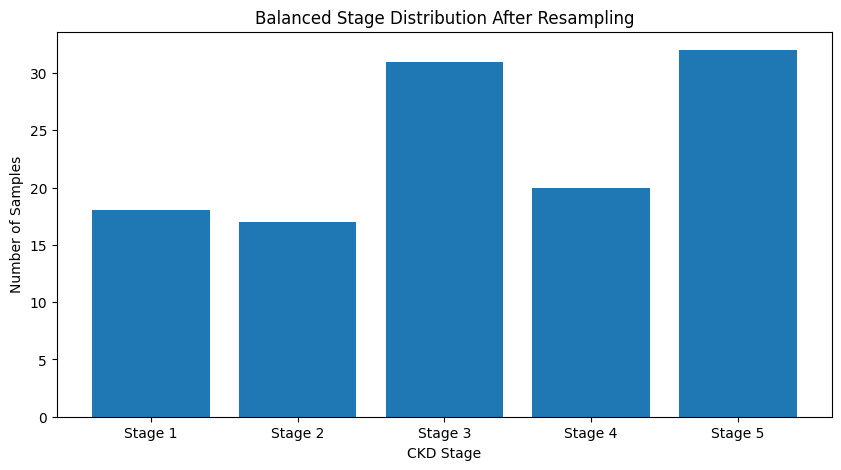

In [18]:
import matplotlib.pyplot as plt

# Plot new stage distribution
plt.figure(figsize=(10,5))
plt.bar(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5'], 
        np.sum(full_s_train, axis=0))
plt.title('Balanced Stage Distribution After Resampling')
plt.xlabel('CKD Stage')
plt.ylabel('Number of Samples')
plt.show()

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

def create_ordinal_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Feature extraction
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    
    # Output 1: CKD classification
    binary_out = Dense(1, activation='sigmoid', name='ckd_status')(x)
    
    # Improved stage prediction branch
    stage_branch = Dense(256, activation='relu')(x)
    stage_branch = Dropout(0.5)(stage_branch)
    stage_branch = Dense(128, activation='relu')(stage_branch)
    
    # Ordinal output (4 binary tasks for stages 1-4)
    ordinal_outputs = []
    for i in range(4):
        out = Dense(1, activation='sigmoid', name=f'stage_{i+1}')(stage_branch)
        ordinal_outputs.append(out)
    
    return Model(inputs=inputs, outputs=[binary_out] + ordinal_outputs)

model = create_ordinal_model(X_train.shape[1:])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 32)      │             320 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 128, 128, 32)      │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 32, 32, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 131072)            │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │      33,554,688 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ckd_status (Dense)            │ (None, 1)                 │         131,073 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage_1 (Dense)               │ (None, 1)                 │             129 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage_2 (Dense)               │ (None, 1)                 │             129 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage_3 (Dense)               │ (None, 1)                 │             129 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage_4 (Dense)               │ (None, 1)                 │             12

 Total params: 33,811,845 (128.98 MB)

 Trainable params: 33,811,845 (128.98 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def ordinal_loss(y_true, y_pred):
    """Custom loss for ordinal stages"""
    losses = []
    for i in range(4):
        # Create binary targets for each threshold
        y_true_binary = tf.cast(y_true > i, tf.float32)
        loss = binary_crossentropy(y_true_binary, y_pred[:,i])
        losses.append(loss)
    return tf.reduce_mean(losses)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'ckd_status': 'binary_crossentropy',
        **{f'stage_{i+1}': ordinal_loss for i in range(4)}
    },
    metrics={
        'ckd_status': 'accuracy',
        **{f'stage_{i+1}': 'accuracy' for i in range(4)}
    },
    loss_weights={
        'ckd_status': 1.0,
        **{f'stage_{i+1}': 0.5 for i in range(4)}
    }
)

In [21]:
# Convert stage labels to ordinal format
def create_ordinal_targets(stages):
    ordinal_targets = []
    for i in range(4):
        ordinal_targets.append((stages > i).astype(int))
    return np.array(ordinal_targets).T

# Only use CKD cases for stage training
ckd_mask = (y_train == 1)
stage_targets = np.argmax(full_s_train[ckd_mask], axis=1)
ordinal_targets = create_ordinal_targets(stage_targets)

# Create dictionary of targets for model
train_targets = {
    'ckd_status': y_train,
    **{f'stage_{i+1}': ordinal_targets[:,i] for i in range(4)}
}

In [22]:
def ordinal_loss(y_true, y_pred):
    """Custom loss for ordinal stages"""
    losses = []
    for i in range(4):
        # Reshape both tensors to ensure matching dimensions
        y_true_binary = tf.reshape(tf.cast(y_true > i, tf.float32), [-1, 1])
        y_pred_binary = tf.reshape(y_pred[:, i], [-1, 1])
        loss = binary_crossentropy(y_true_binary, y_pred_binary)
        losses.append(loss)
    return tf.reduce_mean(losses)

In [23]:
# Check shapes before training
print("Training data shapes:")
print(f"X_train: {X_train.shape}")
print("Target shapes:")
for k, v in train_targets.items():
    print(f"{k}: {v.shape}")

Training data shapes:
X_train: (160, 256, 256, 1)
Target shapes:
ckd_status: (160,)
stage_1: (118,)
stage_2: (118,)
stage_3: (118,)
stage_4: (118,)


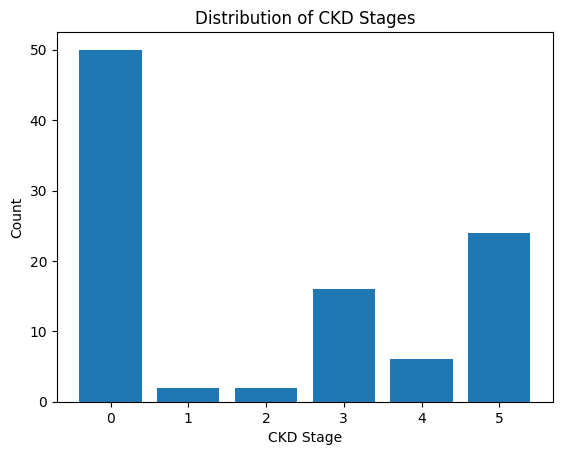

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'stages' is your array of stage labels
unique_stages, counts = np.unique(stages, return_counts=True)
plt.bar(unique_stages, counts)
plt.xlabel('CKD Stage')
plt.ylabel('Count')
plt.title('Distribution of CKD Stages')
plt.show()

In [26]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    # Output 1: CKD classification
    binary_out = Dense(1, activation='sigmoid', name='ckd_status')(x)
    
    # Output 2: Stage prediction (enhanced branch)
    stage_branch = Dense(256, activation='relu')(x)
    stage_branch = Dropout(0.5)(stage_branch)
    stage_branch = Dense(128, activation='relu')(stage_branch)
    stage_branch = Dropout(0.5)(stage_branch)
    stage_out = Dense(5, activation='softmax', name='ckd_stage')(stage_branch)
    
    return Model(inputs=inputs, outputs=[binary_out, stage_out])

model = create_model(X_train.shape[1:])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 256, 256, 32)      │             320 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 128, 128, 32)      │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 64, 64, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 32, 32, 128)       │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 131072)            │               0 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │      33,554,688 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 256)               │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          32,896 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ckd_status (Dense)            │ (None, 1)                 │         131,073 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ckd_stage (Dense)             │ (None, 5)                 │             645 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 33,811,974 (128.98 MB)

 Trainable params: 33,811,974 (128.98 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
%whos

Variable                 Type                 Data/Info
-------------------------------------------------------
Adam                     type                 <class 'keras.src.optimizers.adam.Adam'>
BASE_PATH                str                  C:\Users\saich\charan\kidney\data
CKD_PATH                 str                  C:\Users\saich\charan\kidney\data\CKD
CSV_PATH                 str                  C:\Users\saich\charan\kid<...>a\subject_information.csv
Conv2D                   type                 <class 'keras.src.layers.<...>olutional.conv2d.Conv2D'>
Dense                    type                 <class 'keras.src.layers.core.dense.Dense'>
Dropout                  type                 <class 'keras.src.layers.<...>ization.dropout.Dropout'>
EarlyStopping            type                 <class 'keras.src.callbac<...>_stopping.EarlyStopping'>
Flatten                  type                 <class 'keras.src.layers.<...>shaping.flatten.Flatten'>
HEALTHY_PATH             str         

In [46]:
import numpy as np

# Filter out non-CKD (stage 0) samples using y_stage, and use `images` as input data
ckd_mask = y_stage != 0
X_ckd = images[ckd_mask]
y_ckd = y_stage[ckd_mask]

# Keep non-CKD samples
X_non_ckd = images[~ckd_mask]
y_non_ckd = y_stage[~ckd_mask]

print("CKD class distribution:", np.bincount(y_ckd))


CKD class distribution: [ 0  2  2 16  6 24]
